In [82]:
import os
import imp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import cvxpy as cp

from utils import spectral_analysis
from measurements import constrained_linear_measurement_operator
import matrix_sensitivities as mat_sens

In [24]:
sns.set_context("paper")
plt.style.use("bmh")
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['legend.fontsize'] = 7
matplotlib.rcParams['lines.linewidth'] = 1

## Data Management

In [25]:
def make_sens_ts(dvdp,dvdq,n=274):
    """Make timeseries of sensitivity matrices"""
    assert dvdp.shape[0] == dvdq.shape[0]
    m_tot = dvdp.shape[0] #total measurments
    m = int(m_tot/n) #Timeseries interval
    svp,svq = [],[] #timeseries list of svp and svq matrices
    for t in range(m):
        svp.append(dvdp[t*n:(t+1)*n,:])
        svq.append(dvdq[t*n:(t+1)*n,:])
    return {'svp':svp,
            'svq':svq}

def make_deviations(data):
    """Make finite differences"""
    p,q,v = data
    (dp,dq,dv) = [np.diff(x) for x in (p,q,v)]
    dx = np.vstack((dp,dq))
    return (dx,dv)

def make_S_tilde(svp,svq):
    """Make wide S_tilde matrix"""
    return np.vstack((svp.T,svq.T)).T

def make_S_0(S_tilde,pct_obs):
    """Make initial observed matrix"""
    O,_ = constrained_linear_measurement_operator(S_tilde,pct_obs)
    O,S_0 = np.asarray(O),np.multiply(np.asarray(O),S_tilde)
    return O,S_0

# Modeling Complex Power Injections in the IEEE 123-Bus Case using Voltage Sensitivities

## 1. Hourly Varying Demand, Fixed Power Factor
A constant power factor of $\alpha_i = 0.9, i = 1,\dots,n$ is applied to all loads.

In [26]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/HourlyDemand_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
sens = make_sens_ts(dvdp,dvdq)
data = make_deviations((p,q,v))
(dx,dv) = data
svp,svq = sens['svp'],sens['svq']
print(svp[0].shape,svq[0].shape,dx.shape,dv.shape)

(274, 274) (274, 274) (548, 23) (274, 23)


In [27]:
pct_obs = 0.20
S_tilde = make_S_tilde(svp[0],svq[0])
O,S_0 = make_S_0(S_tilde,pct_obs)

In [28]:
print("Relative pct. error of the 'true' sensitivity matrix: ",np.linalg.norm(dv[:,0] - S_tilde@dx[:,0])/np.linalg.norm(dv[:,0])*100)

Relative pct. error of the 'true' sensitivity matrix:  1.1973718447073551


Text(0.5, 1.0, '20% Observable Sensitivty Matrix (IEEE 123-bus)')

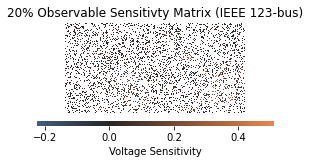

In [6]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
ax = sns.heatmap(np.asarray(S_0),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_0)==0),
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=1e-6,
            cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
            rasterized=True)
ax.set_title("{pct_obs:.0f}% Observable Sensitivty Matrix (IEEE 123-bus)".format(pct_obs=pct_obs*100))

In [89]:
imp.reload(mat_sens)
pf = 0.9*np.ones(S_tilde.shape[0])
K = mat_sens.K(pf)
sqv_impl = [svq_t@K for svq_t in svq]

In [7]:
known_value_indices = tuple(zip(*[[0, 0], [0, 2], [1, 1], [2, 0], [2, 1]]))
known_values = [1.0, 1.9, 0.8, 3.2, 5.9]
X = np.zeros(shape=(3,3))

In [10]:
#Setup parameters
imp.reload(mat_sens)
lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
lamb_.value,delta_.value = 1.25e-1,6e-2

#Solve problem
S_hat,prob = mat_sens.mat_rec_solution(S_0,dx,dv,lamb=lamb_,o=O,delta=delta_)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 09:34:21 AM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 09:34:21 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 09:34:21 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 09:34:21 AM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 09:34:21 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 09:34:21 AM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 09:34:21 AM: Applying reduction CvxAttr2Constr
(CVXPY

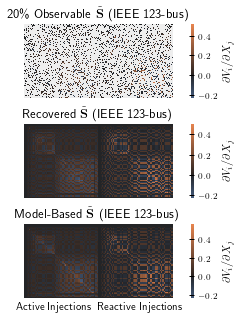

In [79]:
fig,axes = plt.subplots(nrows=3, 
                        figsize=(3.5,2*3.5/1.61828),
                        constrained_layout=True,
                        sharex=True, sharey=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
axes[0] = sns.heatmap(np.asarray(S_0),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_0)==0),
            xticklabels=False,yticklabels=False,ax=axes[0],
            linewidths=1e-6,
            cbar_kws={"label":r"$\partial V_i \big/ \partial X_j$","pad":0.1})
axes[0].set_title(r"{pct_obs:.0f}\%".format(pct_obs=pct_obs*100) + r" Observable $\tilde{\mathbf{S}}$  (IEEE 123-bus)")
#axes[0].set_title(r"{pct_obs:.0f}% Observable $\tilde{\mathbf{S}}$ (IEEE 123-bus)".format(pct_obs=pct_obs*100))
axes[1] = sns.heatmap(S_hat.value,ax=axes[1],
                      cmap=cmap,center=0,square=True,
                      xticklabels=False,yticklabels=False,
                      cbar_kws={"label":r"$\partial V_i \big/ \partial X_j$","pad":0.1})
axes[1].set_title(r"Recovered $\tilde{\mathbf{S}}$ (IEEE 123-bus)")
axes[2] = sns.heatmap(S_tilde,ax=axes[2],
                      cmap=cmap,center=0,square=True,
                      xticklabels=False,yticklabels=False,
                     cbar_kws={"label":r"$\partial V_i \big/ \partial X_j$","pad":0.1})
axes[2].set_title(r"Model-Based $\tilde{\mathbf{S}}$ (IEEE 123-bus)")
axes[2].set_xlabel(r"\ \ \ Active Injections \  Reactive Injections")
#plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spring_22/IEE123_recovery_lamb.125_delta.006.png",dpi=300)

In [85]:
#rel_err_ts = [calc_rel_err(S_hat,make_S_tilde(svp_t,svq_t))*100 for svp_t,svq_t in zip(svp,svq)]

Text(0.5, 1.0, 'Matrix relative error')

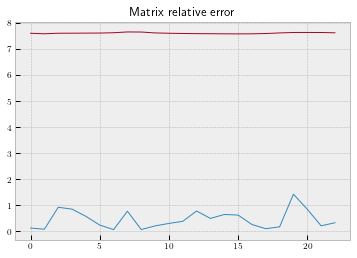

In [77]:
import utils
v_rel_err = []
S_rel_err = []
for t,(dv_t,dx_t) in enumerate(zip(dv.T,dx.T)):
    hat_dv_t = S_hat.value@dx_t
    S_tilde = make_S_tilde(svp[t],svq[t])
    S_rel_err.append(mat_sens.calc_rel_err(S_hat.value,S_tilde)*100)
    v_rel_err.append(utils.calc_vector_rel_err(v_est=hat_dv_t,v_true=dv_t)*100)

#Voltage relative error
plt.plot(v_rel_err)
plt.title("Voltage timeseries relative error (pct)")
#Sensitivity Matrix Relative Error
plt.plot(S_rel_err)
plt.title("Relative Error")


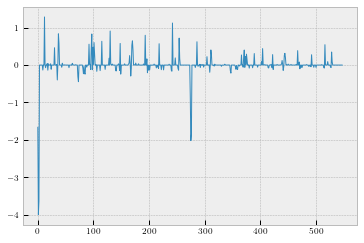

In [98]:
plt.plot(dx[:,7])

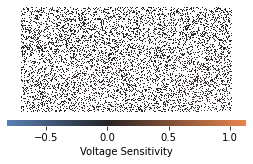

In [374]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
ax = sns.heatmap(np.asarray(S_hat),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_hat)==0),
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=1e-6,
            cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
            rasterized=True)

### Plot the Spectral Analysis for the IEEE 123 Test Feeder

In [100]:
cum_sigma,normed_sigma = spectral_analysis(S_tilde)

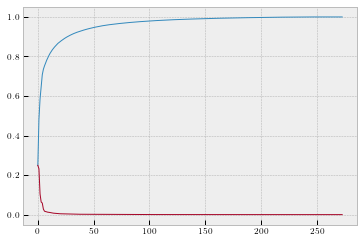

In [102]:
plt.plot(cum_sigma)
plt.plot(normed_sigma)

## 2. Synthetic demands, fixed power factor 

In [ ]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/Synthetic_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
svp,svq = make_sens_ts(dvdp,dvdq)

## 3. Synthetic demands, varying power factor

In [ ]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/Synthetic_DB/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
svp,svq = make_sens_ts(dvdp,dvdq)